In [1]:
import pandas as pd

In [11]:
from sklearn.cluster import KMeans, DBSCAN # clustering algorithms
from sklearn.decomposition import PCA # dimensionality reduction
from sklearn.neighbors import NearestNeighbors # for selecting the optimal eps value when using DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [2]:
import spacy
import re
nlp = spacy.load("en_core_web_sm")

In [3]:
"""
import goodreads_books file and save chunk for dataframe
"""
book_data_chunks = pd.read_json("goodreads_books.json", lines=True, chunksize = 10000)

book_data_sample = []
for c in book_data_chunks:
    book_data_sample.append(c)
    break

book_df = pd.DataFrame(book_data_sample[0])

In [4]:
book_df.head() # view head

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
0,0312853122,1,[],US,,"[{'count': '3', 'name': 'to-read'}, {'count': ...",,false,4.00,,...,9,,1984,https://www.goodreads.com/book/show/5333265-w-...,https://images.gr-assets.com/books/1310220028m...,5333265,3,5400751,W.C. Fields: A Life on Film,W.C. Fields: A Life on Film
1,0743509986,6,[],US,,"[{'count': '2634', 'name': 'to-read'}, {'count...",,false,3.23,B000FC0PBC,...,10,Abridged,2001,https://www.goodreads.com/book/show/1333909.Go...,https://s.gr-assets.com/assets/nophoto/book/11...,1333909,10,1323437,Good Harbor,Good Harbor
2,,7,[189911],US,eng,"[{'count': '58', 'name': 'to-read'}, {'count':...",B00071IKUY,false,4.03,,...,,Book Club Edition,1987,https://www.goodreads.com/book/show/7327624-th...,https://images.gr-assets.com/books/1304100136m...,7327624,140,8948723,"The Unschooled Wizard (Sun Wolf and Starhawk, ...","The Unschooled Wizard (Sun Wolf and Starhawk, ..."
3,0743294297,3282,[],US,eng,"[{'count': '7615', 'name': 'to-read'}, {'count...",,false,3.49,B002ENBLOK,...,7,,2009,https://www.goodreads.com/book/show/6066819-be...,https://s.gr-assets.com/assets/nophoto/book/11...,6066819,51184,6243154,Best Friends Forever,Best Friends Forever
4,0850308712,5,[],US,,"[{'count': '32', 'name': 'to-read'}, {'count':...",,false,3.40,,...,,,,https://www.goodreads.com/book/show/287140.Run...,https://images.gr-assets.com/books/1413219371m...,287140,15,278577,Runic Astrology: Starcraft and Timekeeping in ...,Runic Astrology: Starcraft and Timekeeping in ...


In [5]:
sorted(book_df)

['asin',
 'authors',
 'average_rating',
 'book_id',
 'country_code',
 'description',
 'edition_information',
 'format',
 'image_url',
 'is_ebook',
 'isbn',
 'isbn13',
 'kindle_asin',
 'language_code',
 'link',
 'num_pages',
 'popular_shelves',
 'publication_day',
 'publication_month',
 'publication_year',
 'publisher',
 'ratings_count',
 'series',
 'similar_books',
 'text_reviews_count',
 'title',
 'title_without_series',
 'url',
 'work_id']

In [7]:
"""
Function that groups/lemmatizes descriptions
Reduces the amount of features (words) in the dataset
Function will also clean text of all punctuation
"""

def lemmatize(x):
    doc = nlp(x)
    new_text = []
    for token in doc:
        new_text.append(token.lemma_)
    empty_str = " "
    text_string = empty_str.join(new_text)

    # getting rid of non-word characters
    text_string = re.sub(r"[^\w\s]+", "", text_string)
    text_string = re.sub(r"\s{2,}", " ", text_string)
    return text_string

In [8]:
book_df["description"] = book_df["description"].apply(lemmatize)

In [10]:
book_df.to_csv("description_lemmatized.csv")

In [13]:
"""
Create document vectors for each book description
"""

tfidf = TfidfVectorizer(stop_words = "english") # initalize TF-IDF model and ignore stopwords
book_descriptions_tfidf = tfidf.fit_transform(book_df["description"]) # converts descriptions into vectors

In [14]:
print(f"n_samples: {book_descriptions_tfidf.shape[0]}, n_features: {book_descriptions_tfidf.shape[1]}") # too many features

n_samples: 10000, n_features: 98703


In [16]:
# creating a new TF-IDF matrix
tfidf = TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_features=250, strip_accents="unicode", min_df=10, max_df=200)
tfidf_descriptions_array = tfidf.fit_transform(book_df["description"])
book_descriptions_tfidf = pd.DataFrame(tfidf_descriptions_array.toarray(), index=book_df.index, columns=tfidf.get_feature_names_out())
book_descriptions_tfidf.describe()

,ability,act,agent,alive,allow,animal,apart,appear,approach,army,...,visit,voice,wait,watch,water,wild,writing,yang,year ago,ze
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.005779,0.006162,0.005219,0.007004,0.005886,0.005879,0.006993,0.007025,0.005049,0.006236,...,0.006562,0.007758,0.006836,0.006536,0.006206,0.007608,0.007115,0.008345,0.006171,0.004095
std,0.050006,0.051645,0.049734,0.055171,0.049123,0.059219,0.057247,0.056768,0.046010,0.054847,...,0.057020,0.058957,0.055585,0.053377,0.055348,0.061533,0.059844,0.084347,0.050416,0.051364
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.893746,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.824808,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
"""
reduce the feature space using PCA
"""

pca = PCA(n_components=10, whiten=False, random_state=42)
description_pca = pca.fit_transform(book_descriptions_tfidf)
df_description_pca = pd.DataFrame(data=description_pca)

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
def elbowPlot(range_, data, figsize=(10,10)):
    '''
    the elbow plot function helps to figure out the right amount of clusters for a dataset
    '''
    inertia_list = []
    for n in range_:
        kmeans = KMeans(n_clusters=n, random_state=42)
        kmeans.fit(data)
        inertia_list.append(kmeans.inertia_)
        
    # plotting
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    sns.lineplot(y=inertia_list, x=range_, ax=ax)
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Inertia")
    ax.set_xticks(list(range_))
    fig.show()
    fig.savefig("elbow_plot.png")

C:\Users\rdavis97\AppData\Local\Temp\ipykernel_30408\559783953.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


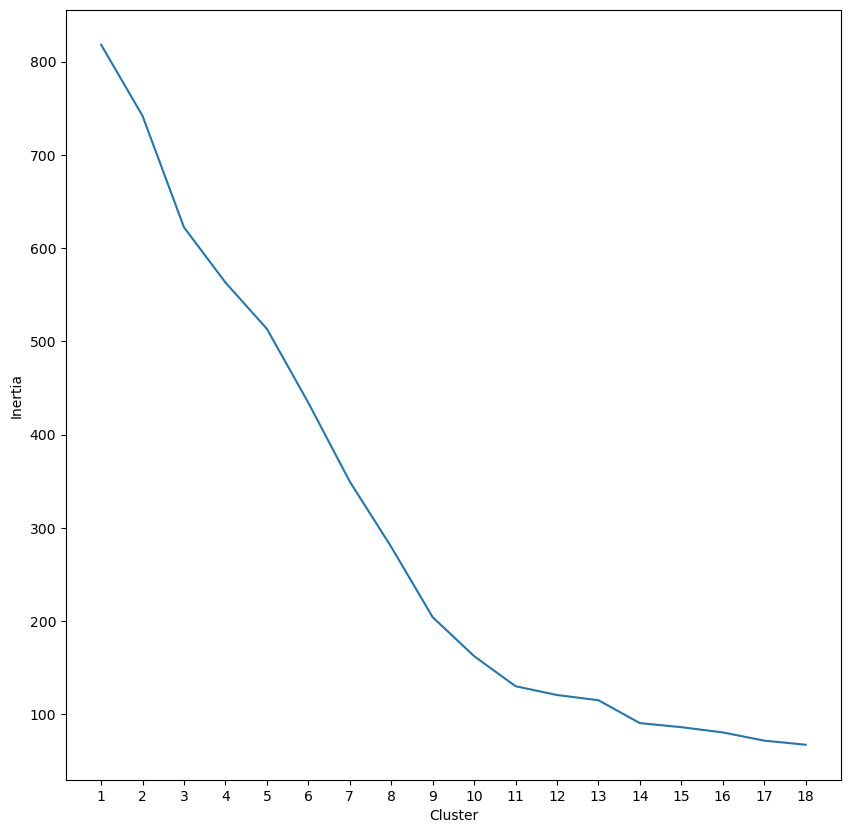

In [21]:
elbowPlot(range(1,19), df_description_pca) # looks like 11 clusters

In [22]:
kmeans = KMeans(n_clusters=11, random_state=42) # create 11 clusters using k means based on elbow plot
descrip_labels = kmeans.fit_predict(df_description_pca)
df_descrip_labeled = book_df.copy()
df_descrip_labeled["cluster"] = descrip_labels

In [23]:
df_descrip_labeled[df_descrip_labeled["cluster"] == 9][["title", "cluster"]] # probably need to breakdown by genre to get better results


,title,cluster
16,Heaven,9
311,Sherlock Holmes: Year One,9
355,"The Beginning (Night Dreams, #1)",9
365,The Ultimate Anti-Career Guide: The Inner Path...,9
588,زندگی بتهوون کتاب دوم: آوای رستاخیز,9
...,...,...
9804,Rapture: Pre-Trib Case Closed,9
9840,Depraved: The Definitive True Story of H.H. Ho...,9
9849,The Man with the Bionic Brain: And Other Victo...,9
9927,آواز بی ساز,9
